In [2]:
import pandas as pd
import numpy as np
from os import listdir
import json

COLUMNS = ["name", "city", "description", "stars", "price", "rating", "reviews", "image", "images",
           "categoryReviews", "userReviews"]
CATEGORIES = ["staff", "facilities", "cleanliness", "comfort", "valueForMoney", "location"]
RCATEGORIES = ["staff", "facilities", "cleanliness", "comfort", "location"]

# reads the file and selects columns
dataframes = []
for file in listdir("../data/listings/"):
    temp_df = pd.read_json(f"../data/listings/{file}")
    temp_df["city"] = file[:-12]
    temp_df = temp_df[COLUMNS]
    dataframes.append(temp_df)
df = pd.concat(dataframes)

# create columns based on review categories
for i, var_name in enumerate(CATEGORIES):
    df[var_name] = df["categoryReviews"].str[i].str['score']

# if duplicate or no reviews are available, drop row
df = df[df["reviews"] > 0]
df = df.dropna()
df = df.drop_duplicates(subset=["name", "city"])

# normalize the values of numerical attributes and adjust buggy prices
df.loc[df["price"] < 5, "price"] = 1000 * df.loc[df["price"] < 10, "price"]
for column in ["stars", "reviews", "rating"] + CATEGORIES:
    df[column] = (df[column] - np.mean(df[column])) / np.std(df[column])

# add the one-hot-encoding for cities
df = pd.concat([df, pd.get_dummies(df["city"])], axis=1)

# change the price to be in log form
df["price"] = np.log(df["price"])

df = df.reset_index(drop=True)

# obtain a big string with reviews
for i in range(df.shape[0]):
    reviews = df.loc[i, "userReviews"]
    new_string = ""
    for review in reviews:
        try:
            new_string += " ".join((review["title"], review["positive"], review["negative"], " "))
        except TypeError:
            pass

    if len(new_string) == 0:
        new_string = "no reviews"

    df.loc[i, "userReviews"] = new_string

# save it as a csv to be used in other places
df.to_csv("data.csv", index=False)
df

,name,city,description,stars,price,rating,reviews,image,images,categoryReviews,...,portland,sacramento,san_antonio,san_diego,san_francisco,san_jose,seattle,toronto,tucson,washington_dc
0,The State Hotel,seattle,"The State Hotel features a fitness center, ter...",0.991736,6.212606,0.597247,-0.503632,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 9.1}, {'title': '...",...,0,0,0,0,0,0,1,0,0,0
1,Hotel Theodore,seattle,You're eligible for a Genius discount at Hotel...,0.991736,5.826000,0.785521,0.154328,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 9.2}, {'title': '...",...,0,0,0,0,0,0,1,0,0,0
2,"Kimpton Hotel Monaco Seattle, an IHG Hotel",seattle,"Located in Central Seattle, Kimpton Hotel Mona...",0.991736,6.084499,0.314835,-0.531155,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 8.9}, {'title': '...",...,0,0,0,0,0,0,1,0,0,0
3,Grand Hyatt Seattle,seattle,Less than 10 minutes’ drive from the Space Nee...,2.234641,6.061457,0.879658,-0.192284,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 9.2}, {'title': '...",...,0,0,0,0,0,0,1,0,0,0
4,citizenM Seattle Pioneer Square,seattle,"Attractively set in Seattle, citizenM Seattle ...",0.991736,5.937536,0.785521,0.033917,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 9.2}, {'title': '...",...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,Hampton Inn & Suites Orlando-Apopka,orlando,"Located in Apopka, Florida, this hotel offers ...",-1.494074,5.062595,0.879658,-0.258510,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 9}, {'title': 'Fa...",...,0,0,0,0,0,0,0,0,0,0
4415,Hyatt Place Orlando/Lake Buena Vista,orlando,"Featuring free WiFi, Hyatt Place Orlando Lake ...",0.991736,5.446737,0.408972,0.322904,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 8.7}, {'title': '...",...,0,0,0,0,0,0,0,0,0,0
4416,Hampton Inn Orlando Near Universal Blv/Interna...,orlando,"Only 1 mi from Universal Studios Florida™, thi...",0.991736,5.187386,-0.155852,0.326344,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 8.3}, {'title': '...",...,0,0,0,0,0,0,0,0,0,0
4417,Homewood Suites by Hilton Orlando-Nearest to U...,orlando,"Experience all of the comforts of home, includ...",-0.251169,5.327876,0.691384,0.659195,https://cf.bstatic.com/images/hotel/max1024x76...,[https://cf.bstatic.com/xdata/images/hotel/max...,"[{'title': 'Staff', 'score': 8.9}, {'title': '...",...,0,0,0,0,0,0,0,0,0,0


Score: 0.773886720753892


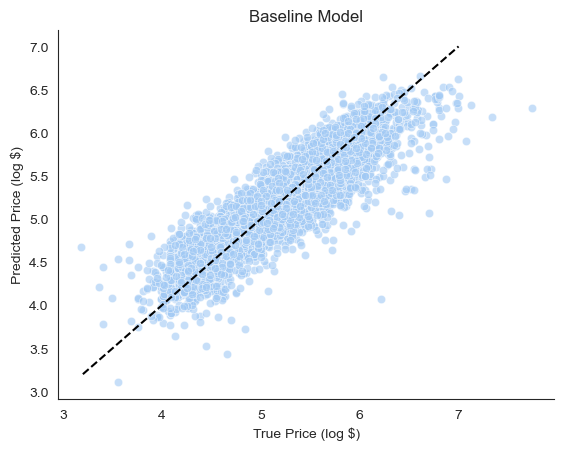

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# run linear regression
X, y = df[["stars", "reviews", "rating"] + RCATEGORIES + list(pd.get_dummies(df["city"]).columns)], df["price"]
reg = LinearRegression().fit(X, y)
predicted = reg.predict(X)
print("Score:", reg.score(X, y))

# plot the data
sns.set_style("white")
sns.set_palette("pastel")
sns.scatterplot(x=y, y=predicted, alpha=0.6)
x_range = np.linspace(3.2, 7, 10)
sns.lineplot(x=x_range, y=x_range, color='k', ls="--")
plt.xlabel("True Price (log $)")
plt.ylabel("Predicted Price (log $)")
plt.title("Baseline Model")
sns.despine()
plt.savefig("../figures/baseline_model.png", dpi=200)
plt.show()

In [4]:
weights = zip(df[["stars", "reviews", "rating"] + RCATEGORIES + list(pd.get_dummies(df["city"]).columns)], reg.coef_)
for i in weights:
    print(i)

('stars', 0.18487433971569367)
('reviews', -0.06428613101674932)
('rating', -0.35812794884966914)
('staff', 0.02768331851129501)
('facilities', 0.30700154623437736)
('cleanliness', -0.03659652519897502)
('comfort', 0.1425320561415007)
('location', 0.1603419685111262)
('albuquerque', 37969811027.787796)
('austin', 37969811027.839645)
('baltimore', 37969811027.91572)
('bonston', 37969811028.54144)
('calgary', 37969811027.794815)
('charlotte', 37969811027.76355)
('chicago', 37969811028.35993)
('columbus', 37969811027.76732)
('dallas', 37969811027.77771)
('denver', 37969811028.23837)
('detroit', 37969811028.17464)
('el_paso', 37969811027.74087)
('fort_worth', 37969811027.61443)
('fresno', 37969811027.87828)
('houston', 37969811027.66312)
('indianapolis', 37969811027.99383)
('jacksonville', 37969811027.75397)
('kansas', 37969811027.76513)
('las_vegas', 37969811027.686806)
('los_angeles', 37969811028.34571)
('louiseville', 37969811027.63989)
('memphis', 37969811027.80187)
('mesa', 3796981102